In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random
using Test

In [3]:
include("src/cost.jl")
include("src/linearize_dynamics.jl")
include("src/lqgame.jl")
include("src/solvelqgame.jl")

solveiLQGame (generic function with 1 method)

### 2D Point Mass Continous dynamics

The 2D point masses with mass $m=1\; \text{kg}$ are subject to input forces $F_{ext}$ and damping coefficient $c = 0.1\;[N \cdot \frac{s}{m}]$.


\begin{split}
\dot p &= v\\
\dot v &= -\frac{b}{m}v + \frac{1}{m}F_{ext}
\end{split}

In [4]:
c = 0.1     # Damping coefficient [N-s/m]
m = 1.0     # Mass [kg]

# State x: [x, y, ̇x, ̇y]
# Input u: [Fₓ, F\_y]

function point_mass(x, u)
    ẋ = x[3]
    ẍ = -(c/m)*ẋ + u[1]/(m)   
    ẏ = x[4]
    ÿ = -(c/m)*ẏ + u[2]/(m)  
    return [ẋ; ẏ; ẍ; ÿ]
end;

#### Point Mass Discrete

The discrete time linear dynamics for two 2D point masses are as described below: 
$$\begin{equation}
    x_{t+1} = A_tx_t + B^1_tu^1_t + B^2_tu^2_t
\end{equation} $$
where the $A_t$ matrix is:
$$\begin{equation}
    A_t = \begin{bmatrix}   1 & 0 & h & 0 & 0 & 0 & 0 & 0               \\ 
                            0 & 1 & 0 & h & 0 & 0 & 0 & 0               \\ 
                            0 & 0 & 1-(c/m_1)*h & 0 & 0 & 0 & 0 & 0     \\ 
                            0 & 0 & 0 & 1-(c/m_1)*h & 0 & 0 & 0 & 0     \\
                            0 & 0 & 0 & 0 & 1 & 0 & h & 0               \\ 
                            0 & 0 & 0 & 0 & 0 & 1 & 0 & h               \\ 
                            0 & 0 & 0 & 0 & 0 & 0 & 1-(c/m_2)*h & 0     \\ 
                            0 & 0 & 0 & 0 & 0 & 0 & 0 & 1-(c/m_2)*h     \\ 
    \end{bmatrix}
\end{equation} $$
the $B^1_t$ and $B^2_t$ matrices are:
$$\begin{equation}
    B^1_t = \begin{bmatrix} 0 & 0       \\ 
                            0 & 0       \\ 
                            h/m_1 & 0   \\ 
                            0 & h/m_1   \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\
    \end{bmatrix},
    B^2_t = \begin{bmatrix} 0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            h/m_2 & 0   \\ 
                            0 & h/m_2   \\
    \end{bmatrix}
\end{equation} $$
the $x_t$, $u^1_t$, and $u^2_t$ vectors are:
$$\begin{equation}
    x_t = \begin{bmatrix}   x_1         \\ 
                            y_1         \\ 
                            \dot{x}_1   \\ 
                            \dot{y}_1   \\ 
                            x_2 \\ y_2  \\ 
                            \dot{x}_2   \\ 
                            \dot{y}_2   \\
    \end{bmatrix},
    u^1_t = \begin{bmatrix} u^1_x   \\
                            u^1_y   \\
    \end{bmatrix},
    u^2_t = \begin{bmatrix} u^2_x   \\ 
                            u^2_y   \\ 
    \end{bmatrix}
\end{equation} $$

The variables $c$, $h$, $m_1$, and $m_2$ are the damping coefficients [N-s/m], time steps [s], mass of the first agent [kg], and mass of the second agent [kg], respectively.

$$\begin{bmatrix} S11 & S12 \\ S21 & S22 \end{bmatrix}
\begin{bmatrix} P1 \\ P2 \end{bmatrix} = 
\begin{bmatrix} Y1 \\ Y2 \end{bmatrix}$$

$$ \begin{bmatrix} R^{11} + (B^{1'} * V₁ * B^1) & (B^{1'} * V₁ * B^2) \\ (B^{2'} * V_2 * B^1) & R^{22} + (B^{2'} * V_2 * B^2) \end{bmatrix}$$

<!-- $$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$ -->


In [5]:
# Setup the problem

dt = 0.1                    # Step size [s]
H = 10.0                    # Horizon [s]
k_steps = Int(H/dt)         # Number of steps (knot points)

# Initial and final states
# x₁, y₁, ̇x₁, ̇y₁, x₂, y₂, ̇x₂, ̇y₂       

x₀= [5.0; 0.0; 0.0; 0.0; 0.0; 5.0; 0.0; 0.0]        # Initial state
xgoal = [5.0; 10.0; 0.0; 0.0; 10.0; 5.0; 0.0; 0.0]; # Final state

In [6]:
# Define cost matrices 

Q1 = sparse(zeros(8,8))     # State cost for agent 1
Q1[1:4,1:4] = 3.0*I(4)
Qn1 = Q1                    # Terminal cost for agent 1

Q2 = sparse(zeros(8,8))     # State cost for agent 2
Q2[5:8,5:8] = 1.0*I(4)
Qn2 = Q2                    # Terminal cost for agent 2

R11 = 1.0*I(2)              # Control cost for player 1
R22 = 1.0*I(2)              # Contorl cost for player 2
R12 = sparse(zeros(2,2))    # Control cost for player 1 associated with player 2's controls
R21 = sparse(zeros(2,2))    # Control cost for player 2 associated with player 1's controls

dmax = 2.0                  # Distance that both agents should keep between each other [m]
ρ = 500.0                   # Penalty factor for violating the distance constraint

# Input constraints
umax = [2.0,2.0]            
umin = [-2.0,-2.0];

In [7]:
xₜ, u1ₜ, u2ₜ = solveiLQGame(x₀, xgoal, Q1, Q2, Qn1, Qn2, R11, R12, R21, R22, umin, umax, dmax, ρ, dt, H);

┌ Info: Saved animation to /home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/assets/two_agent.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/assets/two_agent.gif")
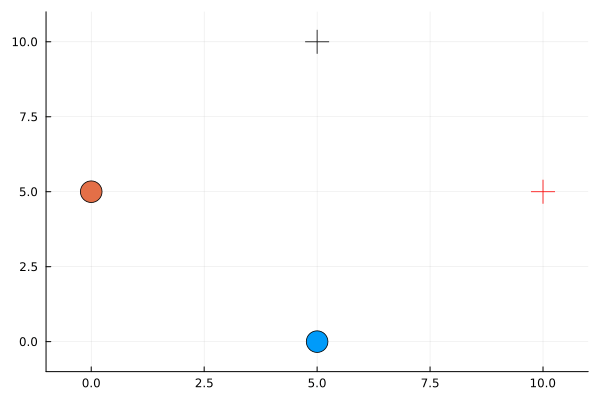

In [8]:
# Animation of the solution. GIF is saved in the assets folder.

anim = @animate for t in 1:k_steps
    scatter([xₜ[t, :][1]], [xₜ[t, :][2]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([xₜ[t, :][5]], [xₜ[t, :][6]], m = (:circle, 12))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :black))
    plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
end every 1;
gif(anim, "assets/two_agent.gif")

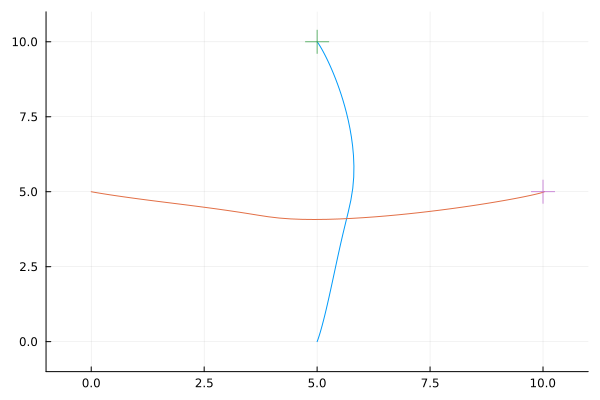

In [9]:
# Trajectories of that the agents followed

plot([xₜ[:, 1]], [xₜ[:, 2]], xlims = (-1, 11), ylims = (-1, 11), legend = false)
plot!([xₜ[:, 5]], [xₜ[:, 6]])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12))

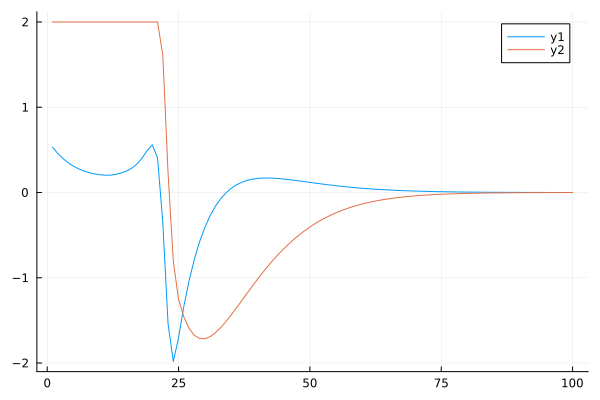

In [10]:
# Agent 1's input values 
# y1: F in x 
# y2: F in y

plot(u1ₜ)

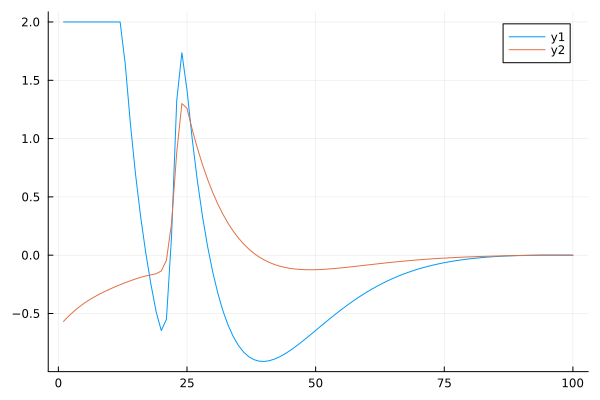

In [11]:
# Agent 2's input values 
# y1: F in x 
# y2: F in y

plot(u2ₜ)